In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
# use this: https://medium.com/@siladityaghosh/efficient-processing-of-large-csv-files-in-python-a-data-engineering-approach-3eabe3623416

In [ ]:
gaze_data  = "/content/drive/MyDrive/masters-project/gaze_data.csv"
subsequences = "/content/drive/MyDrive/masters-project/subsequences.txt"
design = "/content/drive/MyDrive/masters-project/dr(eye)ve_design.txt"


In [ ]:
# reading the data file
gaze_data = pd.read_csv(gaze_data)

# reorganizing the data file
gaze_data = gaze_data.iloc[1: , :]
gaze_data = gaze_data.reset_index(drop=True)



In [ ]:
# reading the subsequences file
subsequences = pd.read_csv(subsequences, sep="\t")


In [ ]:
design = pd.read_csv(design, sep="\t")
design = design.T.reset_index().T.reset_index(drop=True)
design.columns = ['file_number', 'time', 'weather', 'location', 'D', 'train/test']
design.iloc[0, 0] = 1
design

,file_number,time,weather,location,D,train/test
0,1,Evening,Sunny,Countryside,D8,Training Set
1,2,Morning,Cloudy,Highway,D2,Training Set
2,3,Evening,Sunny,Highway,D3,Training Set
3,4,Night,Sunny,Downtown,D2,Training Set
4,5,Morning,Cloudy,Countryside,D7,Training Set
...,...,...,...,...,...,...
69,70,Morning,Rainy,Downtown,D3,Test Set
70,71,Night,Cloudy,Highway,D6,Test Set
71,72,Evening,Cloudy,Downtown,D2,Test Set
72,73,Night,Sunny,Countryside,D7,Test Set


# Data Exploration

In [ ]:
gaze_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301250 entries, 0 to 1301249
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   file_number  1301250 non-null  int64 
 1   frame_etg    1301250 non-null  object
 2   frame_gar    1301250 non-null  object
 3   X            1263848 non-null  object
 4   Y            1263848 non-null  object
 5   event_type   1301250 non-null  object
 6   code         1301250 non-null  object
dtypes: int64(1), object(6)
memory usage: 69.5+ MB


In [ ]:
gaze_data.describe()

,file_number
count,1.301250e+06
mean,3.745919e+01
std,2.139711e+01
min,1.000000e+00
25%,1.900000e+01
50%,3.800000e+01
75%,5.600000e+01
max,7.400000e+01


In [ ]:
gaze_data.isnull().sum()

,0
file_number,0
frame_etg,0
frame_gar,0
X,37402
Y,37402
event_type,0
code,0


In [ ]:
# Adding Timestamp to gaze_data

FRAME_RATE = 30
FRAME_DURATION = 1/FRAME_RATE
gaze_data['frame_gar'] = pd.to_numeric(gaze_data['frame_gar'], errors='coerce')
gaze_data['timestamp'] = gaze_data['frame_gar'] * FRAME_DURATION
gaze_data

,file_number,frame_etg,frame_gar,X,Y,event_type,code,timestamp
0,1,0,0.0,313.81,256.40,Fixation,911066603,0.000000
1,1,0,0.0,313.56,258.52,Saccade,911083143,0.000000
2,1,1,1.0,292.11,259.90,Saccade,911099864,0.033333
3,1,1,1.0,185.82,306.49,Saccade,911116251,0.033333
4,1,2,2.0,143.25,322.21,Saccade,911133030,0.066667
...,...,...,...,...,...,...,...,...
1301245,74,8999,7499.0,405.71,207.12,Saccade,709796963,249.966667
1301246,74,8999,7499.0,495.73,179.57,Saccade,709813635,249.966667
1301247,74,9000,7500.0,589.77,152.12,Saccade,709830213,250.000000
1301248,74,9000,7500.0,690.76,123.23,Fixation,709847356,250.000000


# event distribution type

Analyzing the different event distributions in out gaze data, specifically for events Fixation , Saccade, and Blink.*italicized text*

In [ ]:
event_type_counts = gaze_data['event_type'].value_counts()

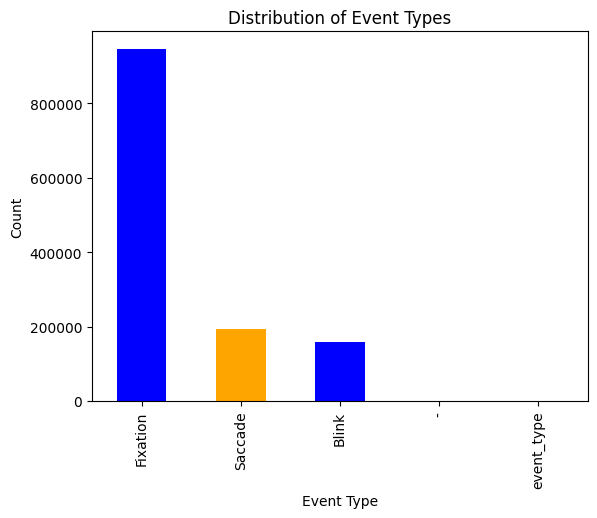

In [ ]:
# Bar plot for events fixation, saccade, and blink
event_type_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

In [ ]:
def event_counter(df):
    """
    Analyzes consecutive occurrences of events within a DataFrame.

    This function calculates two things for each event type in the DataFrame:
    1. The length of consecutive sequences of each event type.
    2. The number of times each event type appears consecutively in these sequences.

    Args:
        df (pd.DataFrame): DataFrame containing at least a column named 'event_type'.

    Returns:
        pd.Series: A Series with the count of consecutive occurrences of each event type.
    """
    result = df.groupby(df['event_type'].ne(df['event_type'].shift()).cumsum())['event_type'].value_counts() # This line had an indentation error
    return result

event_counts = gaze_data.groupby('file_number').apply(event_counter) # Also, '-' was used instead of '_' in the function name
event_counts


file_number  event_type  event_type
1            1           Fixation       1
             2           Saccade        4
             3           Fixation      40
             4           Saccade        7
             5           Fixation      23
                                       ..
74           1496        Fixation      14
             1497        Saccade        5
             1498        Fixation      51
             1499        Saccade        4
             1500        Fixation       2
Name: count, Length: 103322, dtype: int64

In [ ]:
print(event_counts.head())


file_number  event_type  event_type
1            1           Fixation       1
             2           Saccade        4
             3           Fixation      40
             4           Saccade        7
             5           Fixation      23
Name: count, dtype: int64


In [ ]:
print(event_counts.index)

MultiIndex([( 1,    1, 'Fixation'),
            ( 1,    2,  'Saccade'),
            ( 1,    3, 'Fixation'),
            ( 1,    4,  'Saccade'),
            ( 1,    5, 'Fixation'),
            ( 1,    6,  'Saccade'),
            ( 1,    7, 'Fixation'),
            ( 1,    8,  'Saccade'),
            ( 1,    9, 'Fixation'),
            ( 1,   10,  'Saccade'),
            ...
            (74, 1491,  'Saccade'),
            (74, 1492, 'Fixation'),
            (74, 1493,  'Saccade'),
            (74, 1494, 'Fixation'),
            (74, 1495,  'Saccade'),
            (74, 1496, 'Fixation'),
            (74, 1497,  'Saccade'),
            (74, 1498, 'Fixation'),
            (74, 1499,  'Saccade'),
            (74, 1500, 'Fixation')],
           names=['file_number', 'event_type', 'event_type'], length=103322)


# Blink Analysis

In [ ]:
blink_rows = event_counts[event_counts.index.isin(['Blink'], level=2)]
blink_rows

file_number  event_type  event_type
1            14          Blink          32
             40          Blink           9
             106         Blink          33
             118         Blink         129
             120         Blink          27
                                      ... 
74           1463        Blink          11
             1475        Blink          45
             1477        Blink          72
             1479        Blink           8
             1487        Blink           8
Name: count, Length: 6835, dtype: int64

In [ ]:
blink_rows = event_counts[event_counts.index.isin(['Blink'], level=2)]
blink_rows = blink_rows.to_frame()
blink_rows = blink_rows.reset_index(names=['file_number', 'event_type', 'event_number'])


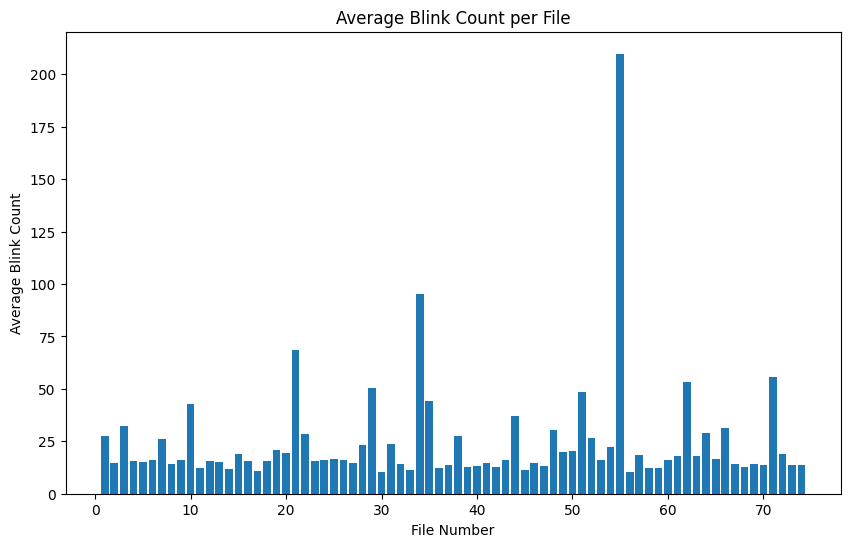

In [ ]:
# Average Blink Count per File
average_counts = blink_rows.groupby('file_number')['count'].mean()

plt.figure(figsize=(10, 6))
plt.bar(average_counts.index, average_counts.values)
plt.xlabel('File Number')
plt.ylabel('Average Blink Count')
_ = plt.title('Average Blink Count per File')


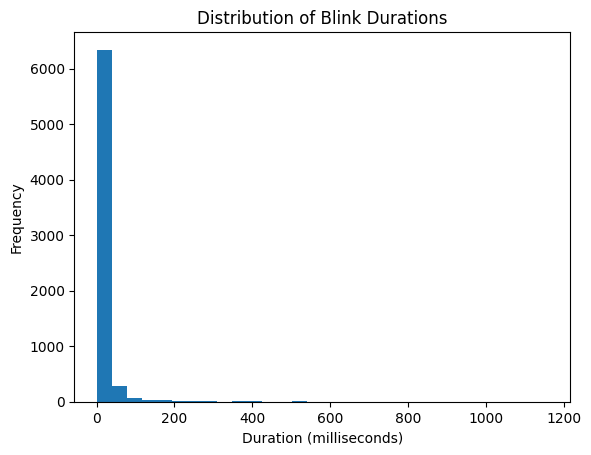

In [ ]:
# Distribution of Blink Durations
plt.hist(blink_rows['count'], bins=30)
plt.title('Distribution of Blink Durations')
plt.xlabel('Duration (milliseconds)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Blink Statistics
blink_stats = blink_rows.groupby('file_number')['count'].agg(['mean', 'std', 'min', 'max'])
print(blink_stats)


                  mean        std  min  max
file_number                                
1            27.608696  28.344855    5  129
2            14.644068   6.957414    7   51
3            32.495652  57.140082    7  424
4            15.433962   7.249693    9   44
5            15.062500  11.698825    7   45
...                ...        ...  ...  ...
70           13.469027   5.416692    8   41
71           55.442857  83.053438    4  408
72           19.000000  20.989375    8  143
73           13.641509  11.183942    7   64
74           13.648148  10.997697    6   72

[74 rows x 4 columns]


In [ ]:
# Merge with Design Data
merged_blink_data = pd.merge(blink_rows, design, on='file_number')
merged_blink_data = merged_blink_data.drop(['event_type', 'D'], axis=1)

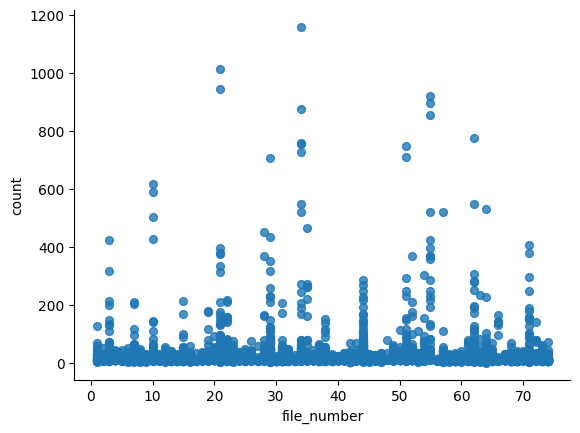

In [ ]:
# File Number vs Count
merged_blink_data.plot(kind='scatter', x='file_number', y='count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# # Average Count by File Number, Weather, and Location
# avg_blink_count = merged_blink_data.groupby(['file_number', 'weather', 'location'])['count'].mean().unstack()
# plt.figure(figsize=(22, 22))
# avg_blink_count.plot(kind='line')
# plt.xlabel('File Number')
# plt.ylabel('Average Blink Count')
# _ = plt.title('Average Blink Count by File Number, Weather, and Location')

In [ ]:
# Merge with Blink Statistics
merged_blink_data = pd.merge(design, blink_stats, on='file_number')

<Figure size 1000x600 with 0 Axes>

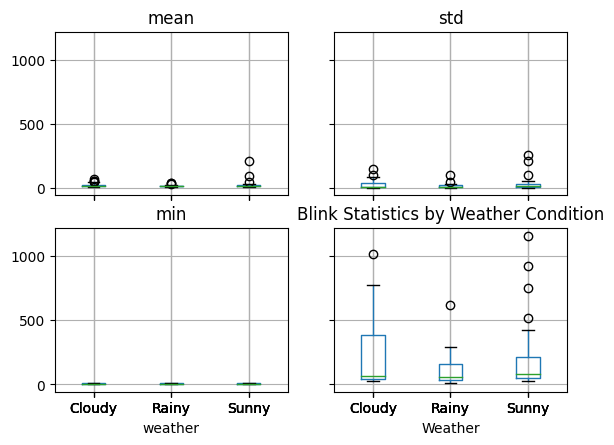

In [ ]:
# Blink Statistics by Weather Condition
plt.figure(figsize=(10, 6))
merged_blink_data.boxplot(column=['mean', 'std', 'min', 'max'], by='weather')
plt.title('Blink Statistics by Weather Condition')
plt.xlabel('Weather')
plt.ylabel('Blink Statistic')
plt.suptitle('')
plt.show()

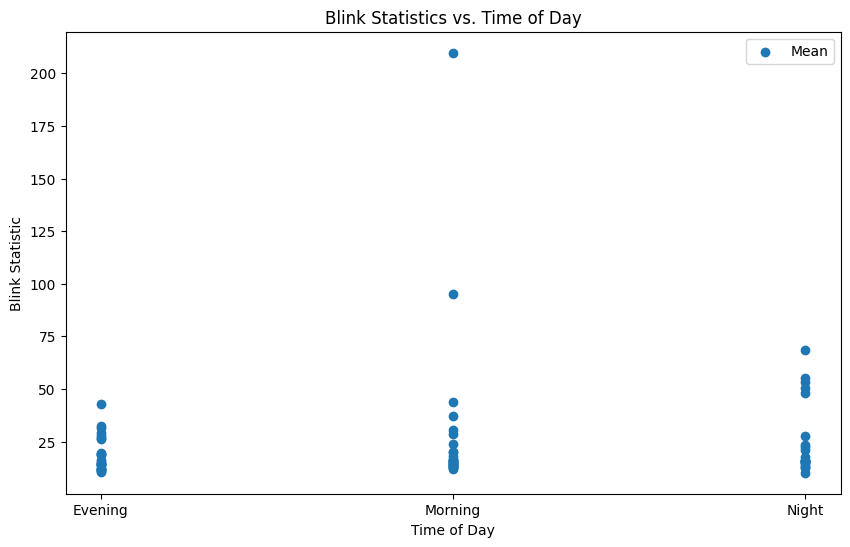

In [ ]:
# Blink Statistics vs. Time of Day
plt.figure(figsize=(10, 6))
plt.scatter(merged_blink_data['time'], merged_blink_data['mean'], label='Mean')
plt.title('Blink Statistics vs. Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Blink Statistic')
plt.legend()
plt.show()


In [ ]:
# Numeric Mappings for Correlation
time_mapping = {'Morning': 1, 'Afternoon': 2, 'Evening': 3}
merged_blink_data['time_numeric'] = merged_blink_data['time'].map(time_mapping)
weather_mapping = {'Sunny': 1, 'Cloudy': 2, 'Rainy': 3}
merged_blink_data['weather_numeric'] = merged_blink_data['weather'].map(weather_mapping)
location_mapping = {'Urban': 1, 'Suburban': 2, 'Rural': 3}
merged_blink_data['location_numeric'] = merged_blink_data['location'].map(location_mapping)

In [ ]:
# Correlation Matrix
print(merged_blink_data.corr(numeric_only=True))

                      mean       std       min       max  time_numeric  \
mean              1.000000  0.934231  0.057473  0.761187     -0.162745   
std               0.934231  1.000000 -0.033235  0.927614     -0.114548   
min               0.057473 -0.033235  1.000000 -0.162649     -0.141695   
max               0.761187  0.927614 -0.162649  1.000000     -0.019927   
time_numeric     -0.162745 -0.114548 -0.141695 -0.019927      1.000000   
weather_numeric  -0.198280 -0.187127  0.038664 -0.181241     -0.161898   
location_numeric       NaN       NaN       NaN       NaN           NaN   

                  weather_numeric  location_numeric  
mean                    -0.198280               NaN  
std                     -0.187127               NaN  
min                      0.038664               NaN  
max                     -0.181241               NaN  
time_numeric            -0.161898               NaN  
weather_numeric          1.000000               NaN  
location_numeric             

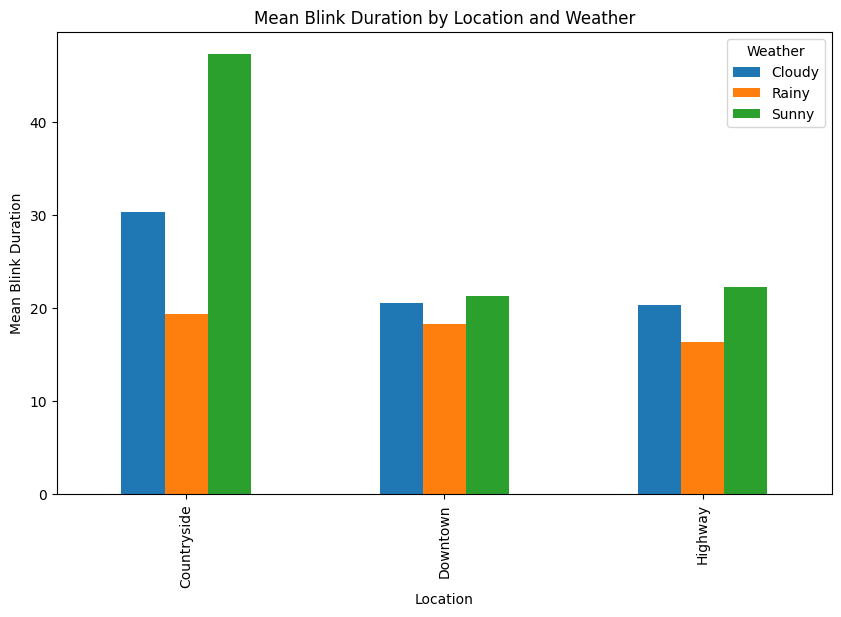

In [ ]:
# Mean Blink Duration by Location and Weather
mean_blink_by_location_weather = merged_blink_data.groupby(['location', 'weather'])['mean'].mean().unstack()
mean_blink_by_location_weather.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Blink Duration by Location and Weather')
plt.xlabel('Location')
plt.ylabel('Mean Blink Duration')
plt.legend(title='Weather')
plt.show()
